In [2]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import os
import scipy.io


img_rows=28
img_cols=20
ff = scipy.io.loadmat('./data/frey_rawface.mat')
ff = ff["ff"].T.reshape((-1, 1, img_rows, img_cols))
ff = ff.astype('float32')/255.

bs = 100
size = len(ff)

ff = ff[:int(size/bs)*bs]

ff_torch = torch.from_numpy(ff)


train_loader = torch.utils.data.DataLoader(ff_torch, batch_size=bs, shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [12]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 560))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=560, h_dim1= 512, h_dim2=256, z_dim=2)
if torch.cuda.is_available():
    vae.cuda()

In [13]:
vae

VAE(
  (fc1): Linear(in_features=560, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=560, bias=True)
)

In [14]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 560), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [24]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        data = Variable(data)
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx == len(train_loader.dataset)/bs-1 :
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t"Minibatch" Loss: {:.6f}'.format(
                epoch, (batch_idx+1) * len(data), len(train_loader.dataset),
                100. * (batch_idx+1) / len(train_loader),
                loss.item()/ len(data)))

In [44]:
for epoch in range(1, 200):
    train(epoch)
    

Train Epoch: 1 [1900/1900 (100%)]	"Minibatch" Loss: 348.449609
Train Epoch: 2 [1900/1900 (100%)]	"Minibatch" Loss: 348.633086
Train Epoch: 3 [1900/1900 (100%)]	"Minibatch" Loss: 347.920859
Train Epoch: 4 [1900/1900 (100%)]	"Minibatch" Loss: 348.071992
Train Epoch: 5 [1900/1900 (100%)]	"Minibatch" Loss: 347.851250
Train Epoch: 6 [1900/1900 (100%)]	"Minibatch" Loss: 347.669375
Train Epoch: 7 [1900/1900 (100%)]	"Minibatch" Loss: 348.233867
Train Epoch: 8 [1900/1900 (100%)]	"Minibatch" Loss: 348.574336
Train Epoch: 9 [1900/1900 (100%)]	"Minibatch" Loss: 348.609023
Train Epoch: 10 [1900/1900 (100%)]	"Minibatch" Loss: 350.193398
Train Epoch: 11 [1900/1900 (100%)]	"Minibatch" Loss: 349.158633
Train Epoch: 12 [1900/1900 (100%)]	"Minibatch" Loss: 348.757812
Train Epoch: 13 [1900/1900 (100%)]	"Minibatch" Loss: 348.417695
Train Epoch: 14 [1900/1900 (100%)]	"Minibatch" Loss: 346.888867
Train Epoch: 15 [1900/1900 (100%)]	"Minibatch" Loss: 347.912031
Train Epoch: 16 [1900/1900 (100%)]	"Minibatch" Lo

Train Epoch: 129 [1900/1900 (100%)]	"Minibatch" Loss: 347.978398
Train Epoch: 130 [1900/1900 (100%)]	"Minibatch" Loss: 348.816133
Train Epoch: 131 [1900/1900 (100%)]	"Minibatch" Loss: 347.503398
Train Epoch: 132 [1900/1900 (100%)]	"Minibatch" Loss: 348.093711
Train Epoch: 133 [1900/1900 (100%)]	"Minibatch" Loss: 347.006992
Train Epoch: 134 [1900/1900 (100%)]	"Minibatch" Loss: 347.357500
Train Epoch: 135 [1900/1900 (100%)]	"Minibatch" Loss: 348.925703
Train Epoch: 136 [1900/1900 (100%)]	"Minibatch" Loss: 347.594453
Train Epoch: 137 [1900/1900 (100%)]	"Minibatch" Loss: 348.352422
Train Epoch: 138 [1900/1900 (100%)]	"Minibatch" Loss: 347.330312
Train Epoch: 139 [1900/1900 (100%)]	"Minibatch" Loss: 348.584414
Train Epoch: 140 [1900/1900 (100%)]	"Minibatch" Loss: 347.768594
Train Epoch: 141 [1900/1900 (100%)]	"Minibatch" Loss: 347.655078
Train Epoch: 142 [1900/1900 (100%)]	"Minibatch" Loss: 348.242148
Train Epoch: 143 [1900/1900 (100%)]	"Minibatch" Loss: 346.212109
Train Epoch: 144 [1900/19

In [45]:
with torch.no_grad():
    z = torch.randn(16, 2).cuda()
    
    sample = vae.decoder(z).cpu()
    
    #plt.imshow(sample.view(28,28), cmap='gray')
    save_image(sample.view(16, 1, 28, 20), './sample_4' +'.png')
    

In [46]:
import numpy as np
from scipy.stats import norm

nx = ny = 10
x_values = torch.linspace(0.05, 0.95, nx)
y_values = torch.linspace(0.05, 0.95, ny)
 
canvas = np.empty((28*ny, 20*nx))


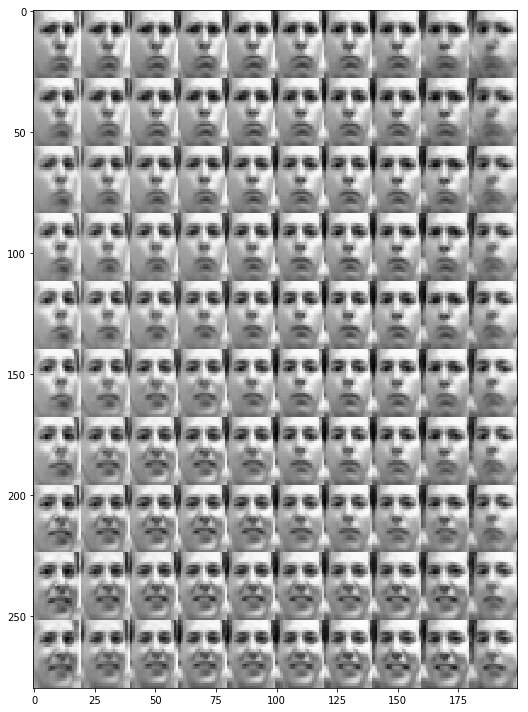

In [47]:
#manifold learning

for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = torch.tensor(np.array([[norm.ppf(xi), norm.ppf(yi)]]).astype('float32'))
        x_mean = vae.decoder(z_mu.cuda()).cpu().detach().numpy()
        
        canvas[(nx-i-1)*28:(nx-i)*28, j*20:(j+1)*20] = x_mean[0].reshape(28, 20)
        
plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()